<h1>Basic test of the wflow BMI interface + reservoir

In [1]:
import wflow.wflow_bmi as bmi
import logging

reload(bmi)
%pylab inline 
import datetime


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Here we define a simple fictious reservoir
reservoirstorage = 15000

def simplereservoir(inputq,storage):
    K = 0.087
    storage = storage + inputq
    outflow = storage * K
    storage = storage - outflow
    
    return outflow, storage



+ The wflow_sbm model calculates the runoff from each cell (the LA land-atmosphere model)


In [13]:
# This is the LAnd Atmophere (LA) model
LA_model = bmi.wflowbmi_csdms()
LA_model.initialize('../../examples/wflow_rhine_sbm/wflow_sbm.ini',loglevel=logging.ERROR)


<h3>Now we can investigate some model parameters

In [14]:
print(LA_model.get_value("timestepsecs"))
print LA_model.get_start_time()

86400
791510400


In [15]:
LA_model.get_attribute_value("run:reinit")

'0'

In [16]:
LA_model.set_attribute_value("run:reinit",'1')
LA_model.get_attribute_value("run:reinit")
LA_model.set_attribute_value("summary:self.TopoLdd","ldd")

In [18]:
LA_model.get_attribute_names()

['inputmapstacks:Precipitation',
 'inputmapstacks:EvapoTranspiration',
 'inputmapstacks:Temperature',
 'inputmapstacks:Inflow',
 'run:starttime',
 'run:endtime',
 'run:runinfo',
 'run:timestepsecs',
 'run:reinit',
 'model:modeltype',
 'model:AnnualDischarge',
 'model:Alpha',
 'model:ModelSnow',
 'model:ScalarInput',
 'model:InterpolationMethod',
 'model:WIMaxScale',
 'model:Tslice',
 'model:UpdMaxDist',
 'model:origTopogLateral',
 'model:configfile',
 'model:reinit',
 'model:fewsrun',
 'model:OverWriteInit',
 'model:updating',
 'model:updateFile',
 'model:lateralmethod',
 'model:sCatch',
 'model:intbl',
 'model:timestepsecs',
 'model:MaxUpdMult',
 'model:MinUpdMult',
 'model:UpFrac',
 'model:waterdem',
 'model:reInfilt',
 'model:MassWasting',
 'model:wflow_subcatch',
 'model:wflow_dem',
 'model:wflow_ldd',
 'model:wflow_river',
 'model:wflow_riverlength',
 'model:wflow_riverlength_fact',
 'model:wflow_landuse',
 'model:wflow_soil',
 'model:wflow_gauges',
 'model:wflow_inflow',
 'model:

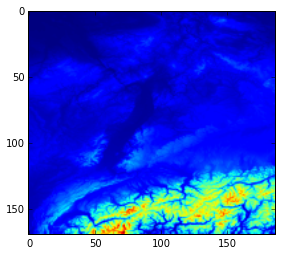

In [19]:
imshow(flipud(LA_model.get_value("Altitude")))

<h3>Start and end times

In [20]:
t_end = LA_model.get_end_time()
t_start = LA_model.get_start_time()
t = LA_model.get_current_time()

(t_end  - t_start)/(86400)



28

In [21]:
grid = LA_model.get_grid_shape("SurfaceRunoff")
Reservoir_idx = (44,61)# y, x
ReservoirDownStreams_idx = (44,60)# y, x

In [22]:
# get the LDD and set a pit at the reservoir location
ldd = flipud(LA_model.get_value("TopoLdd"))
ldd[Reservoir_idx] = 5

LA_model.set_value("TopoLdd",flipud(ldd))


<h3>Now start the models

In [23]:

t_end = LA_model.get_end_time()
t = LA_model.get_start_time()

plotar = []
plotarstorage = []
plotaroutflow = []



while t < t_end:
    
    t = LA_model.get_current_time()
    # Get the inflow from the wflow model (the Q field)
    inflowQ = flipud(LA_model.get_value("SurfaceRunoff"))
    Qin = inflowQ[Reservoir_idx] # Get the single point value 
    # Ru nthe reservoir model
    outflow, reservoirstorage = simplereservoir(Qin, reservoirstorage)
    
    # New set this to the IF variable in wflow
    inflowfield = zeros_like(inflowQ)
    # set the outflow from the reservoir to the downstream location
    inflowfield[ReservoirDownStreams_idx] = outflow
    # Set the new field in the model
    LA_model.set_value("IF",flipud(inflowfield))
    # This not not bemi but needed to update the kinematic wave reservoit
    LA_model.myModel.updateRunOff()
    
    # Now do a timestep
    LA_model.update()
    
    # stuff fro plotting
    plotar.append(Qin)
    plotarstorage.append(reservoirstorage)
    plotaroutflow.append(outflow)
    print datetime.datetime.fromtimestamp(t)


1995-01-31 01:00:00
1995-02-01 01:00:00
1995-02-02 01:00:00
1995-02-03 01:00:00
1995-02-04 01:00:00
1995-02-05 01:00:00
1995-02-06 01:00:00
1995-02-07 01:00:00
1995-02-08 01:00:00
1995-02-09 01:00:00
1995-02-10 01:00:00
1995-02-11 01:00:00
1995-02-12 01:00:00
1995-02-13 01:00:00
1995-02-14 01:00:00
1995-02-15 01:00:00
1995-02-16 01:00:00
1995-02-17 01:00:00
1995-02-18 01:00:00
1995-02-19 01:00:00
1995-02-20 01:00:00
1995-02-21 01:00:00
1995-02-22 01:00:00
1995-02-23 01:00:00
1995-02-24 01:00:00
1995-02-25 01:00:00
1995-02-26 01:00:00
1995-02-27 01:00:00
1995-02-28 01:00:00


In [24]:
LA_model.finalize()


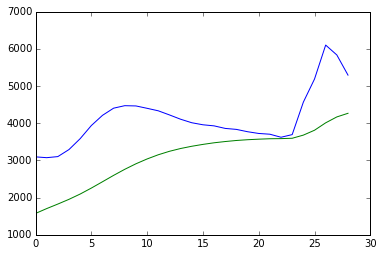

In [26]:
plot(plotar)
plot(plotaroutflow)